In [1]:
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.utils import np_utils

In [5]:
from sklearn.utils import resample
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score

In [7]:
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection

In [8]:
def fit_model(input_dim,encoding_dim, x_train, x_test, nb_epoch, batch_size):
    model = Sequential()
    model.add(Dense(encoding_dim, input_dim=input_dim, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(encoding_dim, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(encoding_dim, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(input_dim,activation='relu'))
    
    model.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data = (x_test, x_test),
                    verbose=0,
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

    return model

In [9]:
df= pd.read_csv("anomaly.csv")

In [10]:
df.head()

,Unnamed: 0,PV Current,PV Voltage,PV Energy,clusters_pred
0,0,59.7,19.4,0.0,0
1,1,59.5,26.8,0.0,0
2,2,59.4,16.1,0.0,0
3,3,59.3,9.1,0.0,0
4,4,59.3,25.2,0.0,0


In [11]:
x = df.copy()
features = ['PV Current','PV Voltage','PV Energy']
x = x[features]
#x = np.expand_dims(x, axis=1)
scaler = StandardScaler()

In [12]:
y = df['clusters_pred']

In [13]:
x_scaled = scaler.fit_transform(x)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.3, shuffle = False)
input_dim = x_train.shape[1]

In [15]:
encoding_dim = 28
nb_epoch = 100
batch_size = 64

In [16]:
n_splits = 20
members = list()

for _ in range(n_splits):
    model = fit_model(input_dim,encoding_dim, x_train, x_test,  nb_epoch, batch_size)
    members.append(model)


Epoch: 0, accuracy:0.0838,  loss:0.6912,  val_accuracy:0.3687,  val_loss:1.3364,  
..............
Epoch: 0, accuracy:0.1082,  loss:0.6831,  val_accuracy:0.5371,  val_loss:0.7534,  
......................
Epoch: 0, accuracy:0.1124,  loss:0.6845,  val_accuracy:0.6080,  val_loss:0.7341,  
...................
Epoch: 0, accuracy:0.1004,  loss:0.6549,  val_accuracy:0.4003,  val_loss:1.6568,  
.......................
Epoch: 0, accuracy:0.0827,  loss:0.6514,  val_accuracy:0.3687,  val_loss:1.3876,  
........................................................
Epoch: 0, accuracy:0.0860,  loss:0.6753,  val_accuracy:0.4315,  val_loss:1.7955,  
.....................................................
Epoch: 0, accuracy:0.1027,  loss:0.6575,  val_accuracy:0.4875,  val_loss:0.7453,  
.................
Epoch: 0, accuracy:0.0961,  loss:0.6483,  val_accuracy:0.3899,  val_loss:0.8684,  
........................
Epoch: 0, accuracy:0.1276,  loss:0.6790,  val_accuracy:0.4298,  val_loss:1.2949,  
................

In [17]:
single_scores, ensemble_scores = [], []
for i in range(1, n_splits+1):
    subset = members[:i]
    yhats = [model.predict(x_test) for model in subset]
    yhats = array(yhats)
    averaged = np.average(yhats, axis=0)
    ensemble = np.mean(np.power(x_test - averaged, 2), axis=0)
    
    *_, y1 = [members[i-1].predict(x_test)]
    single = np.mean(np.power(x_test- y1, 2), axis=0)
    single_scores.append(single)
    ensemble_scores.append(ensemble)

mse single autoencoder 0.719 (0.410)
mse ensemble autoencoder 0.642 (0.191)


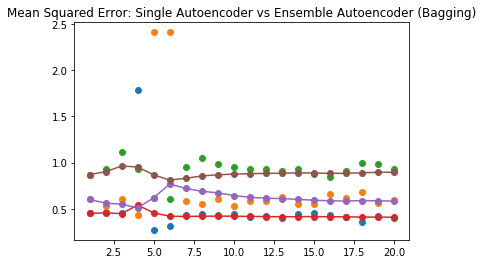

In [18]:
# plot score vs number of ensemble members
print('mse single autoencoder %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
print('mse ensemble autoencoder %.3f (%.3f)' % (mean(ensemble_scores), std(ensemble_scores)))
x_axis = [i for i in range(1, n_splits+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
plt.title("Mean Squared Error: Single Autoencoder vs Ensemble Autoencoder (Bagging)")
pyplot.show()

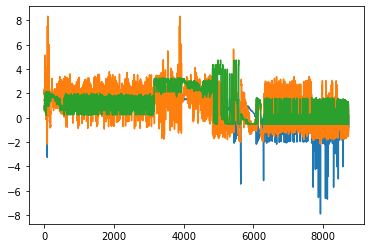

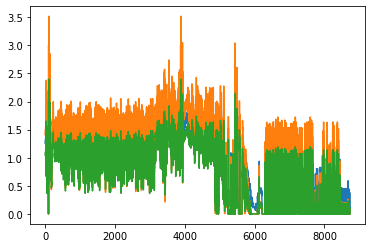

In [19]:
plt.plot(x_test)
plt.show()
plt.plot(averaged)
plt.show()

In [20]:
test_mse = np.mean(np.power(x_test - averaged, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': test_mse, 'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,8727.000000,8727.000000
mean,0.628542,0.196860
std,1.019027,0.397649
min,0.018541,0.000000
25%,0.134563,0.000000
50%,0.273896,0.000000
75%,0.718518,0.000000
max,22.417240,1.000000


In [21]:
threshold = np.max(test_mse)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  22.417239615422748


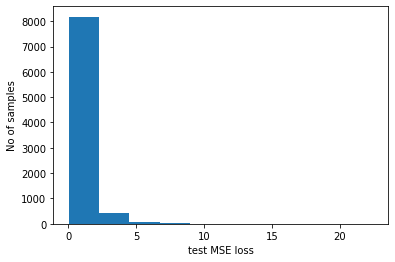

Number of anomaly samples:  4855
Indices of anomaly samples:  (array([   0,    6,    7, ..., 8724, 8725, 8726], dtype=int64),)


In [22]:
test_mse = test_mse.reshape((-1))
plt.hist(test_mse, bins=10)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mse >= 0.221).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

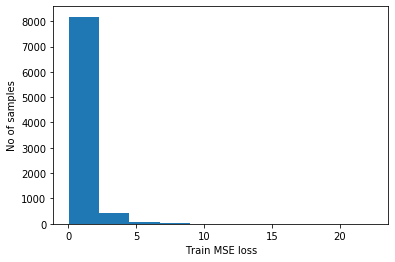

In [23]:
plt.hist(test_mse, bins=10)
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()

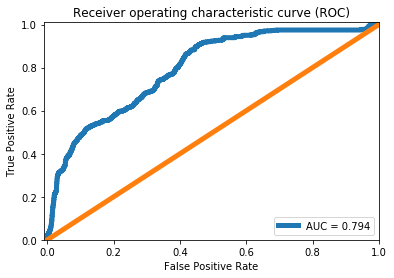

In [24]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
thresholds

array([2.34172396e+01, 2.24172396e+01, 1.18956860e+01, ...,
       1.97044593e-02, 1.93255785e-02, 1.85407711e-02])

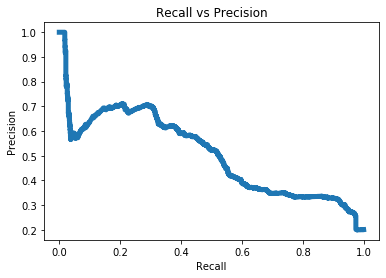

In [26]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [27]:
threshold_rt

array([ 0.03209352,  0.03209626,  0.03218493, ..., 15.27863797,
       15.57190873, 22.41723962])

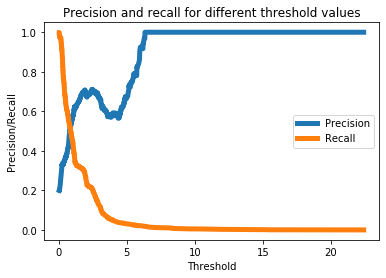

In [28]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [29]:
def detect_mad_outliers(points, threshold=3.5):  
    
    # calculate the median of the input array
    median = np.median(points, axis=0)
    
    # calculate the absolute difference of each data point to the calculated median
    deviation = np.abs(points - median)
    
    # take the median of those absolute differences
    med_abs_deviation = np.median(deviation)
    
    # 0.6745 is the 0.75th quartile of the standard normal distribution,
    # to which the MAD converges.
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    # return as extra information what the original mse value was at which the threshold is hit
    # need to find a way to compute this mathematically, but I'll just use the index of the nearest candidate for now
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value

In [30]:
Z_SCORE_THRESHOLD = 3

# find the outliers on our reconstructions' mean squared errors
mad_z_scores, threshold_value = detect_mad_outliers(test_mse, threshold=Z_SCORE_THRESHOLD)
mad_outliers = (mad_z_scores > Z_SCORE_THRESHOLD).astype(int)

In [31]:
threshold_value

1.1085545533782362

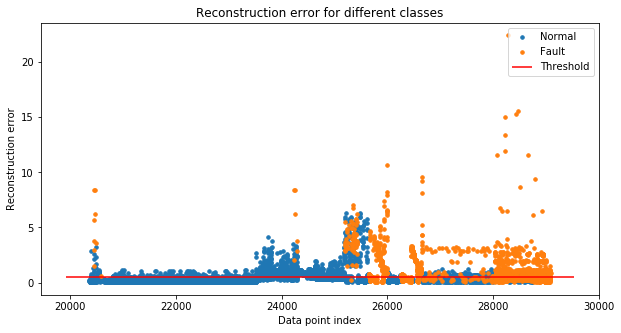

In [47]:
threshold_fixed = 0.5
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index.values, group.Reconstruction_error.values, marker='o', ms=3.5, linestyle='',
            label= "Fault" if name == 1 else "Normal")    
    
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.gcf().set_size_inches(10, 5)
plt.show();

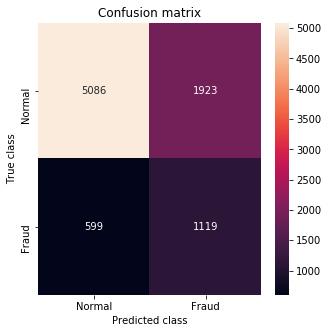

In [48]:
y_val_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_val_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [49]:
print(classification_report(y_test, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      7009
           1       0.37      0.65      0.47      1718

    accuracy                           0.71      8727
   macro avg       0.63      0.69      0.64      8727
weighted avg       0.79      0.71      0.74      8727



In [50]:
roc_auc_score(y_test, error_df.Reconstruction_error.values)

0.7940012599798928

In [51]:
confusion_matrix(y_test, y_val_pred)

array([[5086, 1923],
       [ 599, 1119]], dtype=int64)